In [1]:
!pip install ipython-autotime

In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import os
from urllib.request import urlopen,urlretrieve
%matplotlib inline
from sklearn.utils import shuffle

from keras.models import load_model
from sklearn.datasets import load_files   
from keras.utils import np_utils
from glob import glob
from keras import applications
from keras.preprocessing.image import ImageDataGenerator 
from keras import optimizers
from keras.models import Sequential,Model,load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D,GlobalAveragePooling2D, BatchNormalization, MaxPooling2D
from keras.callbacks import TensorBoard,ReduceLROnPlateau,ModelCheckpoint,EarlyStopping
from tqdm import tqdm
from keras.preprocessing import image
%load_ext autotime


time: 85 µs (started: 2021-05-17 10:10:57 +00:00)


LOAD DATASET FROM GOOGLE DRIVE & AUGMENTASI

In [3]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
time: 2.1 ms (started: 2021-05-17 10:10:57 +00:00)


In [5]:
trdata = ImageDataGenerator(horizontal_flip=True,vertical_flip=True,rotation_range= 90)
traindata = trdata.flow_from_directory(directory="drive/My Drive/IDCAMP/Project 1 : Image Classification/Dataset/train",batch_size=64,target_size=(227,227))

vddata = ImageDataGenerator(horizontal_flip=True,vertical_flip=True,rotation_range= 90)
validatedata = vddata.flow_from_directory(directory="drive/My Drive/IDCAMP/Project 1 : Image Classification/Dataset/validation",batch_size=64,target_size=(227,227))

Found 1314 images belonging to 3 classes.
Found 874 images belonging to 3 classes.
time: 219 ms (started: 2021-05-17 10:12:32 +00:00)


BUILD MODEL DENGAN ARSITEKTUR CLOUDNET

In [6]:
#Arsitektur diambil dari paper ini 
#source paper : https://www.researchgate.net/publication/326873190_CloudNet_Ground-Based_Cloud_Classification_With_Deep_Convolutional_Neural_Network

#create model
model = Sequential()
#add model layers
#Conv1 
model.add(Conv2D(96, kernel_size=11, activation='relu', input_shape=(227,227,3),strides=4))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=3,strides=2))
#conv2
model.add(Conv2D(96, kernel_size=5,activation='relu',strides=1, padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=3,strides=2))
#conv3
model.add(Conv2D(256, kernel_size=3,activation='relu',strides=1,padding='same'))
model.add(BatchNormalization())
#conv4
model.add(Conv2D(384, kernel_size=3,activation='relu',strides=1,padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=3,strides=2))
model.add(Flatten())
#fc
model.add(Dense(9216,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4096,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 55, 55, 96)        34944     
_________________________________________________________________
batch_normalization (BatchNo (None, 55, 55, 96)        384       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 27, 27, 96)        230496    
_________________________________________________________________
batch_normalization_1 (Batch (None, 27, 27, 96)        384       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 96)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 256)       2

In [7]:
model.compile(loss = "categorical_crossentropy", optimizer = optimizers.SGD(lr=0.001, momentum=0.9,decay = 0.9), metrics=["accuracy"])

time: 15.1 ms (started: 2021-05-17 10:12:43 +00:00)


HYPERPARAMETER Cyclical Learning Rate (CLR)

In [8]:
!cp "/content/drive/My Drive/IDCAMP/Project 1 : Image Classification/learningratefinder.py" . 
!cp "/content/drive/My Drive/IDCAMP/Project 1 : Image Classification/clr_callback.py" .
from learningratefinder import LearningRateFinder
from clr_callback import CyclicLR

time: 282 ms (started: 2021-05-17 10:12:46 +00:00)


[INFO] finding learning rate...
Epoch 1/4
21/21 [==============================] - 24s 740ms/step - loss: 3.1454 - accuracy: 0.2820
Epoch 2/4
21/21 [==============================] - 16s 768ms/step - loss: 3.0633 - accuracy: 0.3240
Epoch 3/4
21/21 [==============================] - 16s 762ms/step - loss: 3.0871 - accuracy: 0.2961
Epoch 4/4
21/21 [==============================] - 16s 761ms/step - loss: 4.0038 - accuracy: 0.4462
[INFO] learning rate finder complete


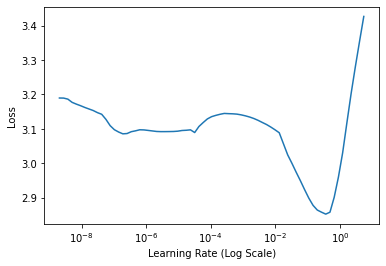

time: 1min 17s (started: 2021-05-17 10:12:47 +00:00)


In [9]:
#Disini CLR digunakan agar learning rate berubah2 seiring proses training, hal ini dilakukan untuk mencegah model berada pada saddle point dan local minima

#source : https://arxiv.org/abs/1506.01186

print("[INFO] finding learning rate...")
lrf = LearningRateFinder(model)
lrf.find(traindata,1e-10, 1e+1,stepsPerEpoch=np.ceil((1314/float(64))),batchSize=64,epochs=4)
lrf.plot_loss()

print("[INFO] learning rate finder complete")

In [10]:
# Set CLR options
base_lr = 1e-2
max_lr = 0.5
mode='triangular'

# Define the callback
clr = CyclicLR(base_lr=base_lr, max_lr=max_lr, mode=mode)

time: 1.66 ms (started: 2021-05-17 10:15:56 +00:00)


TRAINING & VALIDATION

In [11]:
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=30, verbose=1, mode='auto')
callbacks_list = [clr,early]
history = model.fit_generator(generator= traindata, epochs= 100, validation_data= validatedata, validation_steps=1, callbacks=callbacks_list)

#Callback pertama yaitu CLR, dan yang kedua earlystopping.

#Early Stopping digunakan untuk mengentikan proses training ketika akurasi tidak lagi naik pada sekian epoch yang ditentukan.
#Disini saya melakukan training dengan 100 epoch dan patience 30, yaitu ketika 30 epoch akurasi tidak naik maka proses training akan dihentikan.

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
21/21 [==============================] - 19s 898ms/step - loss: 137.8071 - accuracy: 0.3204 - val_loss: 8000.6025 - val_accuracy: 0.3125
Epoch 2/100
21/21 [==============================] - 17s 830ms/step - loss: 19.8551 - accuracy: 0.4627 - val_loss: 537.1561 - val_accuracy: 0.3125
Epoch 3/100
21/21 [==============================] - 18s 837ms/step - loss: 3.1183 - accuracy: 0.4711 - val_loss: 146.6160 - val_accuracy: 0.2969
Epoch 4/100
21/21 [==============================] - 18s 852ms/step - loss: 2.6431 - accuracy: 0.5099 - val_loss: 31.1923 - val_accuracy: 0.3594
Epoch 5/100
21/21 [==============================] - 18s 849ms/step - loss: 1.8126 - accuracy: 0.5761 - val_loss: 44.9345 - val_accuracy: 0.3438
Epoch 6/100
21/21 [==============================] - 18s 844ms/step - loss: 1.7013 - accuracy: 0.6157 - val_loss: 9.7437 - val_accuracy: 0.3438
Epoch 7/100
21/21 [==============================] - 17s 831ms/step - loss: 1.9566 - accuracy: 0.6271 - val_loss: 4.9864 - v

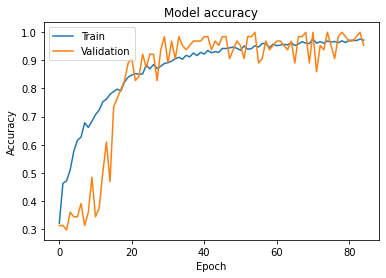

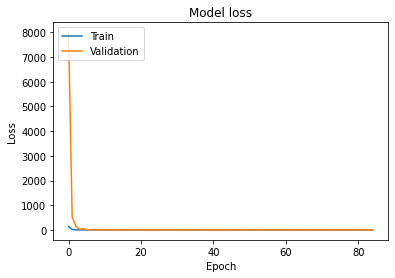

time: 287 ms (started: 2021-05-17 10:43:35 +00:00)


In [12]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [13]:
model.save('/content/drive/My Drive/IDCAMP/Project 1 : Image Classification/model-100Epoch-cloudnet-lrf-augmentation.h5')

time: 6.55 s (started: 2021-05-17 10:43:58 +00:00)


TESTING

Saving e5dFezMV6TxIvNXA.png to e5dFezMV6TxIvNXA.png
scissors


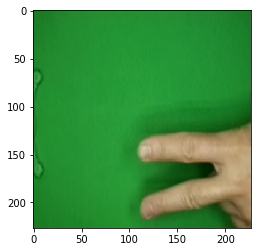

time: 8.41 s (started: 2021-05-17 11:22:07 +00:00)


In [25]:
#paper class 0
#rock class 1
#scissors class 2

import numpy as np
from google.colab import files
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline


up_files = files.upload()
 
for fn in up_files.keys():
 
  path = fn
  img = image.load_img(path, target_size=(227,227))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
 
  images = np.vstack([x])
  classes = model.predict(images,batch_size=10)
  
  if np.argmax(classes)==0:
    print('paper')
  elif np.argmax(classes)==1:
    print('rock')
  else:
    print('scissors')

In [ ]:
#Semua files yang dipakai disimpan pada https://drive.google.com/drive/folders/1MheiBWo_sowMwV5nEqNQbk_j439fDAeE?usp=sharing